In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics

In [62]:
data = pd.read_csv('../data/diabetes.csv')

In [63]:
df = data.copy()

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [65]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [66]:
cols = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
df[cols] = df[cols].replace(0, np.nan)

In [67]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

imputer = SimpleImputer(strategy='median')
df[cols] = imputer.fit_transform(df[cols])

In [68]:
df['Insulin_log'] = np.log1p(df['Insulin'])
df = df.drop(columns=['Insulin'])

In [69]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Outcome,Insulin_log
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.656250,72.386719,29.108073,32.455208,0.471876,33.240885,0.348958,4.827137
std,3.369578,30.438286,12.096642,8.791221,6.875177,0.331329,11.760232,0.476951,0.494893
min,0.000000,44.000000,24.000000,7.000000,18.200000,0.078000,21.000000,0.000000,2.708050
25%,1.000000,99.750000,64.000000,25.000000,27.500000,0.243750,24.000000,0.000000,4.808086
50%,3.000000,117.000000,72.000000,29.000000,32.300000,0.372500,29.000000,0.000000,4.836282
75%,6.000000,140.250000,80.000000,32.000000,36.600000,0.626250,41.000000,1.000000,4.853976
max,17.000000,199.000000,122.000000,99.000000,67.100000,2.420000,81.000000,1.000000,6.741701


In [70]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

In [71]:
X = df.drop(['Outcome'], axis=1)  # Features
y = df['Outcome']                 # Target

In [72]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [73]:
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
print(neg / pos)


1.8826291079812207


In [74]:
xgb_model = XGBClassifier(
    n_estimators=200,        # Number of trees
    learning_rate=0.1,       # Step size
    max_depth=3,             # Depth of each tree
    subsample=0.8,           # Fraction of data per tree
    colsample_bytree=0.8,    # Fraction of features per tree
    scale_pos_weight=neg/pos,      # Handles imbalanced classes (adjust based on your data)
    use_label_encoder=False, # To suppress warning
    eval_metric='logloss',   # For binary classification
    random_state=42
)


In [75]:
xgb_model.fit(X_train, y_train)
y_proba = xgb_model.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.4).astype(int)


c:\Users\POWER\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [17:39:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [78]:
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


XGBoost Accuracy: 0.7207792207792207
              precision    recall  f1-score   support

           0       0.86      0.68      0.76        99
           1       0.58      0.80      0.67        55

    accuracy                           0.72       154
   macro avg       0.72      0.74      0.71       154
weighted avg       0.76      0.72      0.73       154



In [79]:
models = [
    "Decision Tree",
    "Bagging",
    "Random Forest",
    "AdaBoost",
    "Gradient Boosting",
    "XGBoost"
]

recall_class_1 = [
    0.62,  # Decision Tree
    0.69,  # Bagging
    0.69,  # Random Forest
    0.71,  # AdaBoost
    0.71,  # Gradient Boosting
    0.80   # XGBoost
]


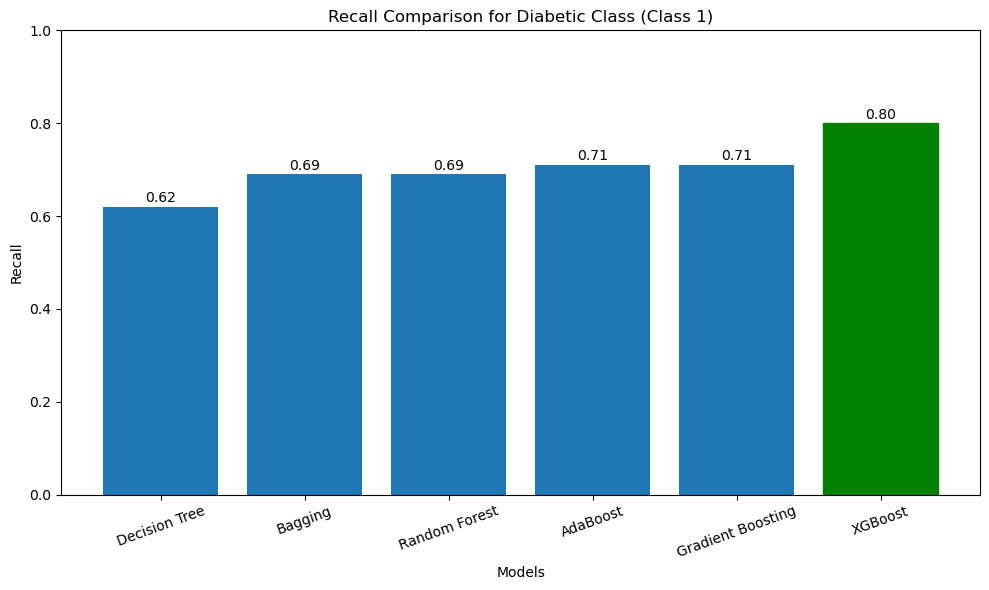

In [80]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

bars = plt.bar(models, recall_class_1)

plt.title("Recall Comparison for Diabetic Class (Class 1)")
plt.ylabel("Recall")
plt.xlabel("Models")
plt.ylim(0, 1)

# Highlight XGBoost bar
bars[-1].set_color("green")

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.01,
        f"{height:.2f}",
        ha="center",
        fontsize=10
    )

plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


In [82]:
plt.savefig("recall_comparison.png", dpi=300, bbox_inches="tight")


<Figure size 640x480 with 0 Axes>